In [1]:
import glob
import os
import regex as re
import pandas as pd
import numpy as np
import random

import librosa
from IPython.display import Audio

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import classification_report
sns.set_style("darkgrid")

# Some Utility Function and Class

In [129]:
def same_seed(seed): 
    '''Fixes random number generator seeds for reproducibility.'''
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    if torch.backends.mps.is_available():
        torch.mps.manual_seed(seed)

In [3]:
class GettingDatasetInfo:
    def __init__(self):
        self.root_dir = os.getcwd()
        self.parent_dir = "Kaggle_Datasets"
        
    def AudioWAV_dataset(self):
        datasetname = "AudioWAV"
        paths = list(glob.glob(os.path.join(self.root_dir, self.parent_dir, datasetname, "*")))
        labels = [path.split("/")[-1].split("_")[-2] for path in paths]
        data = {"Label":labels, "Path":paths}
        df = pd.DataFrame(data)
        
        common_labels = ["angry", "disgust", "sad", "fear", "happy", "neutral"]
        origin_labels = df.Label.value_counts().index.tolist()
        label_dict = dict([(o, c) for o, c in zip(origin_labels, common_labels)])
        df["Label"] = df["Label"].replace(label_dict)
        return df
    
    def TESS_dataset(self):
        datasetname = "TESS Toronto emotional speech set data"
        dirs = list(glob.glob(os.path.join(self.root_dir, self.parent_dir, datasetname, "*")))
        dir_label_dict = dict([(_dir, _dir.split("/")[-1].split("_")[-1].lower()) for _dir in dirs])
        label_modify = {"surprised":"surprise"}
        datainfo = pd.DataFrame()
        for _dir in dirs:
            paths = glob.glob(os.path.join(_dir, "*"))
            labels = [dir_label_dict[_dir]] * len(paths)
            data = {"Label":labels, "Path":paths}
            df = pd.DataFrame(data)
            datainfo = pd.concat((datainfo, df))
        datainfo["Label"] = datainfo["Label"].replace(label_modify)
        return datainfo
    
    def RAVDESS_dataset(self):
        datasetname = "RAVDESS"
        paths = list(glob.glob(os.path.join(self.root_dir, self.parent_dir, datasetname, "*", "*")))
        emotion_dict = {"01" : "neutral", "02" : "calm", \
                        "03" : "happy", "04" : "sad", \
                        "05" : "angry", "06" : "fear",\
                        "07" : "disgust", "08" : "surprise"}
        data = [[emotion_dict[path.split("/")[-1].split("-")[:3][-1]], path]for path in paths]
        datainfo_df = pd.DataFrame(data, columns=["Label", "Path"])
        return datainfo_df
    
    def SAVEE_dataset(self):
        datasetname = "SAVEE"
        pattern = r"[a-zA-z]+"
        #anger, disgust, fear, happiness, sadness and surprise
        paths = list(glob.glob(os.path.join(self.root_dir, self.parent_dir, datasetname, "*")))
        emotion_dict = {"sa" : "sad", "su" : "surprise", \
                        "n" : "neutral", "f" : "fear", \
                        "h" : "happy", "d" : "disgust", "a" : "angry"}
        data = [[re.findall(pattern, os.path.basename(path).split("_")[-1].split(".")[0])[0], path]for path in paths]
        datainfo_df = pd.DataFrame(data, columns=["Label", "Path"])
        datainfo_df["Label"] = datainfo_df["Label"].replace(emotion_dict)
        return datainfo_df
            
    
    def from_all_avaiable_source(self):
        subset1 = self.AudioWAV_dataset()
        subset2 = self.TESS_dataset()
        subset3 = self.RAVDESS_dataset()
        subset4 = self.SAVEE_dataset()
        datainfo = pd.concat((subset1, subset2, subset3, subset4))
        return datainfo
    
obj = GettingDatasetInfo()
datainfo = obj.from_all_avaiable_source()
datainfo

,Label,Path
0,angry,/Users/wangxinping/Desktop/study_in_Canda/GBC_...
1,angry,/Users/wangxinping/Desktop/study_in_Canda/GBC_...
2,neutral,/Users/wangxinping/Desktop/study_in_Canda/GBC_...
3,neutral,/Users/wangxinping/Desktop/study_in_Canda/GBC_...
4,disgust,/Users/wangxinping/Desktop/study_in_Canda/GBC_...
...,...,...
475,angry,/Users/wangxinping/Desktop/study_in_Canda/GBC_...
476,angry,/Users/wangxinping/Desktop/study_in_Canda/GBC_...
477,neutral,/Users/wangxinping/Desktop/study_in_Canda/GBC_...
478,surprise,/Users/wangxinping/Desktop/study_in_Canda/GBC_...


# FeatureExtraction:
- Zero Crossing Rate
- Chroma_stft
- MFCC
- RMS(root mean square) value
- MelSpectogram to train our model.

In [104]:
class FeatureExtraction:
    def __init__(self, datainfo_df, augmentation=True, scaling=True, encoding_y=True):
        self.labels = datainfo_df["Label"].tolist()
        self.datapaths = datainfo_df["Path"].tolist()
        self.augmentation = augmentation
        self.scaling = scaling
        self.encoding_y = encoding_y

    
    def extract_features(self, data, sampling_rate):
        # ZCR
        zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    
        # Chroma_stft
        stft = np.abs(librosa.stft(data))
        chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sampling_rate).T, axis=0)
    
        # MFCC
        mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sampling_rate).T, axis=0)
    
        # Root Mean Square Value
        rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    
        # MelSpectogram
        mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sampling_rate).T, axis=0)
        result = np.hstack((zcr, chroma_stft, mfcc, rms, mel))
        return result
    
    def noise(self, data):
        noise_amp = 0.035*np.random.uniform()*np.amax(data)
        data += noise_amp*np.random.normal(size=data.shape[0])
        return data

    def stretch(self, data, rate=0.8):
        # 0.8 speed of original rate
        return librosa.effects.time_stretch(data, rate=rate)

    def shift(self, data):
        shift_range = int(np.random.uniform(low=-5, high=5)*1000)
        # positive for count from left direction, 
        # negative for count from right direction
        return np.roll(data, shift_range)

    def pitch(self, data, sampling_rate, pitch_factor=0.7):
        return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)
    
    def main(self):
        X = []
        y = []
        for label, data_path in zip(self.labels, self.datapaths):
            data, sampling_rate = librosa.load(data_path)
            feats = self.extract_features(data=data, sampling_rate=sampling_rate)
            X.append(feats)
            y.append(label)
            if self.augmentation:
                noise_data = self.noise(data)
                noise_feats = self.extract_features(noise_data, sampling_rate=sampling_rate)
                X.append(noise_feats)
                y.append(label)
                
                shift_data = self.shift(data)
                shift_pitch_data = self.pitch(shift_data, sampling_rate=sampling_rate)
                shift_pitch_feats = self.extract_features(shift_pitch_data, sampling_rate=sampling_rate)
                X.append(shift_pitch_feats)
                y.append(label)
        dataset = pd.DataFrame(X)
        if self.scaling:
            scaler = StandardScaler()
            dataset = pd.DataFrame(scaler.fit_transform(dataset))
        dataset["Label"] = y
        if self.encoding_y:
            labelencoder = LabelEncoder()
            encode_y = labelencoder.fit_transform(dataset["Label"])
        dataset["Label"] = encode_y
        return dataset, labelencoder
    
obj = FeatureExtraction(datainfo_df=datainfo, augmentation=True)
dataset, labelencoder = obj.main()
print(dataset.shape)
print(dataset.head())

/Users/wangxinping/anaconda3/envs/nlp/lib/python3.11/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


(12162, 163)
          0         1         2         3         4         5         6   
0 -0.096757  0.320638 -0.302586 -0.296104 -0.459816 -0.239838 -0.715126  \
1 -0.154470  0.069575 -0.801788 -0.499180  0.259533 -0.256553 -0.535680   
2 -0.559108 -0.098197 -0.664810 -0.373961 -0.203965  0.284929  0.625404   
3 -0.532489  0.485433  0.419302  0.292227 -0.116225  0.418252  0.593544   
4 -0.805782  0.413298  0.379369  0.323064  0.415479  0.474659  0.564990   

          7         8         9  ...       153       154       155       156   
0 -0.472955 -0.119085 -0.070053  ... -0.265817 -0.257656 -0.257384 -0.267765  \
1  0.032150 -0.077087 -0.397006  ... -0.265817 -0.257656 -0.257384 -0.267765   
2  1.055342  1.081624  0.581067  ... -0.265817 -0.257656 -0.257383 -0.267765   
3  0.621095  0.425131  0.277055  ... -0.265817 -0.257656 -0.257383 -0.267765   
4  0.730797  0.829676  0.119146  ... -0.265816 -0.257656 -0.257383 -0.267765   

        157       158       159       160       161  La

<Axes: xlabel='Label'>

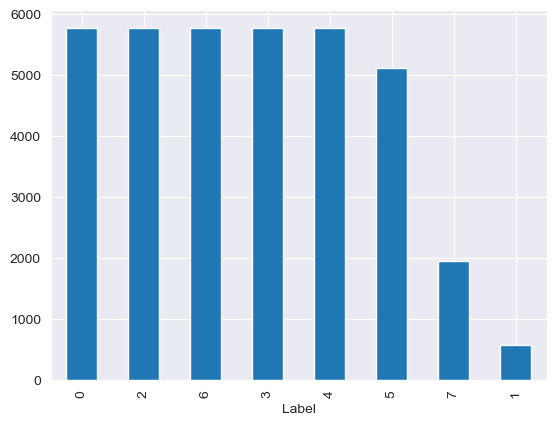

In [32]:
dataset["Label"].value_counts().plot(kind="bar")

# Configuration

In [101]:
config = {
        "random_seed":1314520,
        "batch_size":64,
        "epochs": 500,
        "learning_rate":1e-3,
        "patience":100
}
if torch.backends.mps.is_available():
    device = "mps"

elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
device

'mps'

# Dataset

In [94]:
def train_test_valid_split(dataset, test_ratio=0.1, valid_ratio=0.1, seed=1314520):
    np.random.seed(seed)
    random.seed(seed)
    n_samples = len(dataset)
    idxs_list = list(range(len(dataset)))
    random.shuffle(idxs_list)
    num_test, num_valid = int(n_samples*test_ratio), int(n_samples*valid_ratio)
    test_idxs = idxs_list[:num_test]
    valid_idxs = idxs_list[num_test:num_test+num_valid]
    train_idxs = idxs_list[num_test+num_valid:]
    return np.array(dataset.iloc[train_idxs,:]), np.array(dataset.iloc[test_idxs, :]), np.array(dataset.iloc[valid_idxs, :])
    
class AudioDataset(Dataset):
    def __init__(self, dataset):
        super().__init__()
        #MPS GPU cannot support float64, so use float() convert it to float32
        self.X = torch.from_numpy(dataset[:, :-1]).float()
        self.y = torch.LongTensor(dataset[:, -1])
        
    def __len__(self):
        return self.X.size()[0]
        
    def __getitem__(self, idx):
        return self.X[idx, :], self.y[idx]

# Model

In [42]:
class Classifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(32, output_dim)
        )
        
    def forward(self, x):
        return self.layer(x)

# Training Function

In [63]:
def trainer(model, device, train_loader, valid_loader, config, model_name="best_model"):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])
    
    epochs, patience, c_patience, min_loss  \
                                  = config["epochs"], config["patience"], 0, np.inf
    # output of the function
    history = dict(train_loss=[], train_acc=[], val_loss=[], val_acc=[])
    writer = SummaryWriter()
    
    for epoch in range(epochs):
        
        #training
        model.train()
        avg_loss = []
        avg_acc = []
        train_pbar = tqdm(train_loader, position=0, leave=True)
        
        for X, y in train_pbar:
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            output = model(X)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            
            _, pred_y = torch.max(output, -1)
            acc = (pred_y == y).sum() / len(y)
            avg_loss.append(loss.detach().item())
            avg_acc.append(acc.detach().item())
            
            train_pbar.set_description(f"Epoch:{epoch+1}")
            train_pbar.set_postfix({"loss":loss.detach().item(), "acc":acc.detach().item()})
        
        train_loss = np.mean(avg_loss)
        train_acc = np.mean(avg_acc)
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        
        #validation
        model.eval()
        avg_loss = []
        avg_acc = []
        valid_pbar = tqdm(valid_loader, position=0, leave=True)
        
        for X, y in valid_pbar:
            X, y = X.to(device), y.to(device)
            with torch.no_grad():
                output = model(X)
                
            loss = criterion(output, y)
            _, pred_y = torch.max(output, -1)
            acc = (pred_y == y).sum() / len(y)
            avg_loss.append(loss.detach().item())
            avg_acc.append(acc.detach().item())
            
            valid_pbar.set_description(f"Epoch:{epoch+1}")
            valid_pbar.set_postfix({"val_loss":loss.detach().item(), 'val_acc':acc.detach().item()})
            
        valid_loss = np.mean(avg_loss)
        valid_acc = np.mean(avg_acc)
        history["val_loss"].append(valid_loss)
        history["val_acc"].append(valid_acc)
        
        #writer.add_scalars("Loss", {"train":train_loss, "valid":valid_loss}, epoch+1)
        #writer.add_scalars("Accuracy", {"train":train_acc, "valid":valid_acc}, epoch+1)
        writer.add_scalar("Loss/train", train_loss, epoch+1)
        writer.add_scalar("Accuracy/train", train_acc, epoch+1)

        writer.add_scalar("Loss/valid", valid_loss, epoch+1)
        writer.add_scalar("Accuracy/valid", valid_acc, epoch+1)
        
        # Earlystopping checkpoint
        if valid_loss < min_loss:
            min_loss = valid_loss
            torch.save(model.state_dict(), f"./{model_name}.pth")
            print(f"Saving the best model with avg_loss:{round(valid_loss,2)} avg_acc:{round(valid_acc,2)}.")
            c_patience = 0
        else:
            c_patience +=1
            if c_patience >= patience:
                print(f"Model is not improving for secutive {c_patience} epochs. Halt the training.")
                break
    return history

# Main Part
- step1: Fixing random seed
- step2: Create dataset with predefined **AudioDataset** class and load it with DataLoader()
- step3: create the model start the training process with predefined **trainer** function
  - inputs of the **trainer** function
    - model(with assigned deviece)
    - assigned device
    - train_loader
    - valid_loader
    - config
    - model_name

In [106]:
same_seed(config["random_seed"])

train_data, test_data, valid_data = \
train_test_valid_split(dataset, test_ratio=0.1, valid_ratio=0.1, seed=1314520)
print(train_data.shape, test_data.shape, valid_data.shape)
train_dataset, test_dataset, valid_dataset = \
    AudioDataset(train_data), AudioDataset(test_data), AudioDataset(valid_data)

train_loader, test_loader, valid_loader = \
   DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True, pin_memory=True),\
   DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=True, pin_memory=True),\
   DataLoader(valid_dataset, batch_size=config["batch_size"], shuffle=True, pin_memory=True)

batch = next(iter(train_loader))
print(batch[0].shape, batch[1].shape)

(9730, 163) (1216, 163) (1216, 163)
torch.Size([64, 162]) torch.Size([64])


In [107]:
# training
input_dim, output_dim = train_data.shape[1]-1, len(labelencoder.classes_)
print("input_dim:", input_dim, "output_dim:", output_dim)
model = Classifier(input_dim, output_dim).to(device)
model_name = f"model_lr_{str(config['learning_rate'])}_batch_{str(config['batch_size'])}_no_aug"
print("model_name:", model_name)
history = trainer(model, device, train_loader, valid_loader, config, model_name=model_name)

input_dim: 162 output_dim: 8
model_name: model_lr_0.001_batch_64_no_aug


Epoch:1: 100%|███| 19/19 [00:00<00:00, 295.04it/s, val_loss=1.61, val_acc=0.359]


Saving the best model with avg_loss:1.51 avg_acc:0.45.


Epoch:2: 100%|███| 19/19 [00:00<00:00, 303.03it/s, val_loss=1.26, val_acc=0.516]


Saving the best model with avg_loss:1.34 avg_acc:0.47.


Epoch:3: 100%|███| 19/19 [00:00<00:00, 287.43it/s, val_loss=1.19, val_acc=0.531]


Saving the best model with avg_loss:1.29 avg_acc:0.5.


Epoch:4: 100%|████| 19/19 [00:00<00:00, 299.39it/s, val_loss=1.2, val_acc=0.453]


Saving the best model with avg_loss:1.21 avg_acc:0.5.


Epoch:5: 100%|███| 19/19 [00:00<00:00, 282.44it/s, val_loss=1.22, val_acc=0.469]


Saving the best model with avg_loss:1.17 avg_acc:0.52.


Epoch:6: 100%|█████| 19/19 [00:00<00:00, 241.93it/s, val_loss=1.19, val_acc=0.5]


Saving the best model with avg_loss:1.15 avg_acc:0.53.


Epoch:8: 100%|███| 19/19 [00:00<00:00, 305.74it/s, val_loss=1.11, val_acc=0.609]


Saving the best model with avg_loss:1.13 avg_acc:0.55.


Epoch:11: 100%|██| 19/19 [00:00<00:00, 316.16it/s, val_loss=1.09, val_acc=0.531]


Saving the best model with avg_loss:1.13 avg_acc:0.54.


Epoch:14: 100%|██| 19/19 [00:00<00:00, 327.37it/s, val_loss=1.32, val_acc=0.469]


Saving the best model with avg_loss:1.09 avg_acc:0.57.


Epoch:17: 100%|██| 19/19 [00:00<00:00, 317.27it/s, val_loss=1.23, val_acc=0.578]


Saving the best model with avg_loss:1.08 avg_acc:0.56.


Epoch:22: 100%|██| 19/19 [00:00<00:00, 310.95it/s, val_loss=1.11, val_acc=0.562]


Saving the best model with avg_loss:1.07 avg_acc:0.56.


Epoch:44: 100%|█████| 19/19 [00:00<00:00, 318.46it/s, val_loss=1.3, val_acc=0.5]


Saving the best model with avg_loss:1.06 avg_acc:0.59.


Epoch:46: 100%|█| 19/19 [00:00<00:00, 346.25it/s, val_loss=0.982, val_acc=0.594]


Saving the best model with avg_loss:1.06 avg_acc:0.59.


Epoch:97: 100%|████████████| 153/153 [00:01<00:00, 104.44it/s, loss=2.28, acc=0]


Epoch:102: 100%|███████████| 153/153 [00:01<00:00, 116.80it/s, loss=1.66, acc=0]
Epoch:102: 100%|█| 19/19 [00:00<00:00, 328.78it/s, val_loss=0.891, val_acc=0.656
Epoch:107: 100%|███████████| 153/153 [00:01<00:00, 103.83it/s, loss=1.34, acc=0]
Epoch:107: 100%|█| 19/19 [00:00<00:00, 295.07it/s, val_loss=0.973, val_acc=0.594
Epoch:108: 100%|███████████| 153/153 [00:01<00:00, 112.34it/s, loss=3.66, acc=0]
Epoch:108: 100%|█| 19/19 [00:00<00:00, 309.33it/s, val_loss=0.755, val_acc=0.656
Epoch:110: 100%|█████████| 153/153 [00:01<00:00, 111.37it/s, loss=0.79, acc=0.5]
Epoch:110: 100%|█| 19/19 [00:00<00:00, 299.08it/s, val_loss=0.932, val_acc=0.625
Epoch:112: 100%|█████████| 153/153 [00:01<00:00, 110.34it/s, loss=4.24, acc=0.5]
Epoch:112: 100%|█| 19/19 [00:00<00:00, 294.01it/s, val_loss=0.802, val_acc=0.688
Epoch:124: 100%|███████████| 153/153 [00:01<00:00, 108.05it/s, loss=6.55, acc=0]
Epoch:124: 100%|█| 19/19 [00:00<00:00, 303.18it/s, val_loss=0.935, val_acc=0.672
Epoch:135: 100%|█████████| 1

Model is not improving for secutive 100 epochs. Halt the training.


In [108]:
%reload_ext tensorboard
%tensorboard --logdir=./runs/

Reusing TensorBoard on port 6006 (pid 8979), started 1:31:27 ago. (Use '!kill 8979' to kill it.)

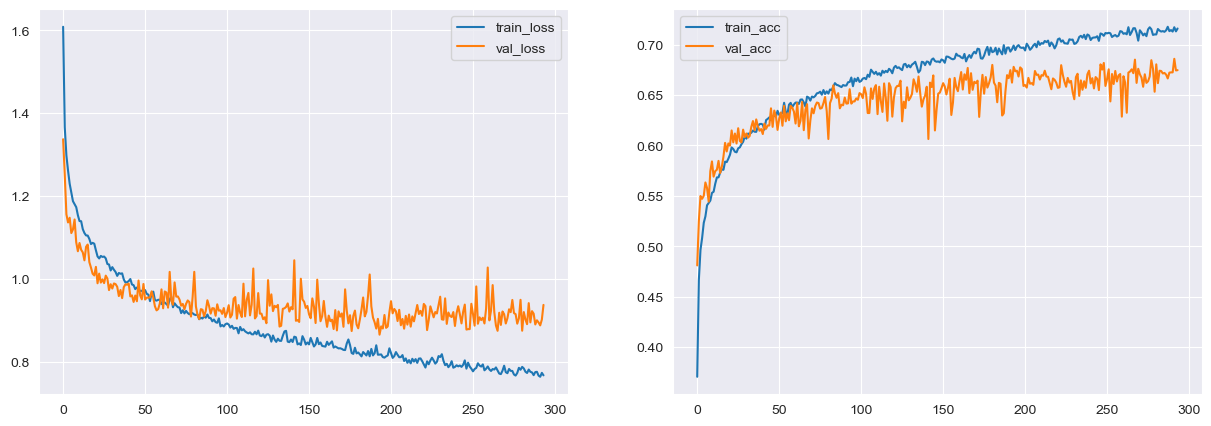

In [71]:
def customize_plot(history):
    history_df = pd.DataFrame(history)
    fig, ax = plt.subplots(1,2, figsize=(15,5))
    history_df[["train_loss", "val_loss"]].plot(ax=ax[0])
    history_df[["train_acc", "val_acc"]].plot(ax=ax[1])
    
history_aug = history
customize_plot(history_aug)

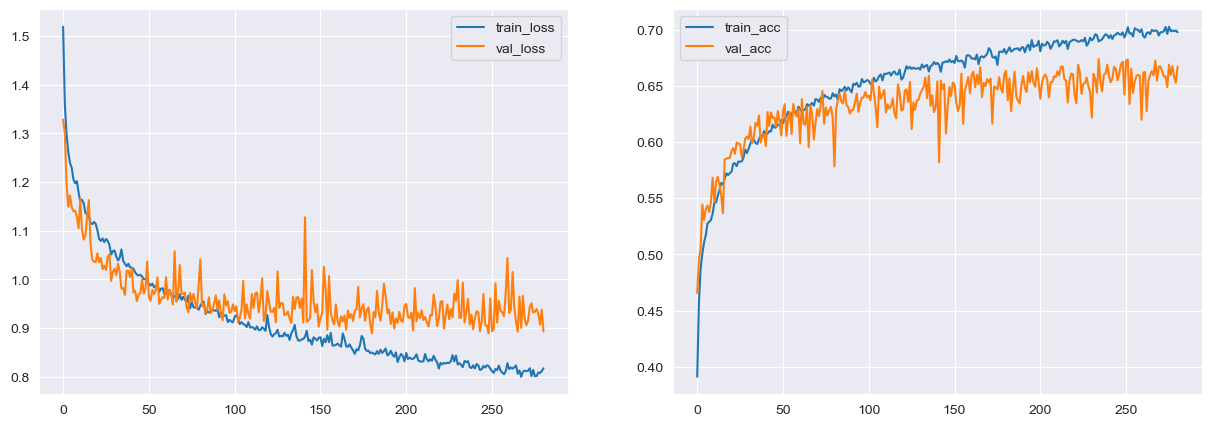

In [99]:
history_lr = history
customize_plot(history_lr)

# Inference on test dataset

100%|██████████████████████████████████████████| 19/19 [00:00<00:00, 162.77it/s]


test_avg_loss:1.1061041951179504, test_avg_acc:0.5855263157894737


100%|██████████████████████████████████████████| 19/19 [00:00<00:00, 341.53it/s]


test_avg_loss:0.8469225795645463, test_avg_acc:0.6743421052631579


100%|██████████████████████████████████████████| 19/19 [00:00<00:00, 364.47it/s]


test_avg_loss:0.8223441494138617, test_avg_acc:0.6883223684210527


,model_name,Test_Accuracy
2,model_lr_0.005_batch_64,0.69
1,model_lr_0.001_batch_64,0.67
0,model_lr_0.001_batch_64_no_aug,0.59


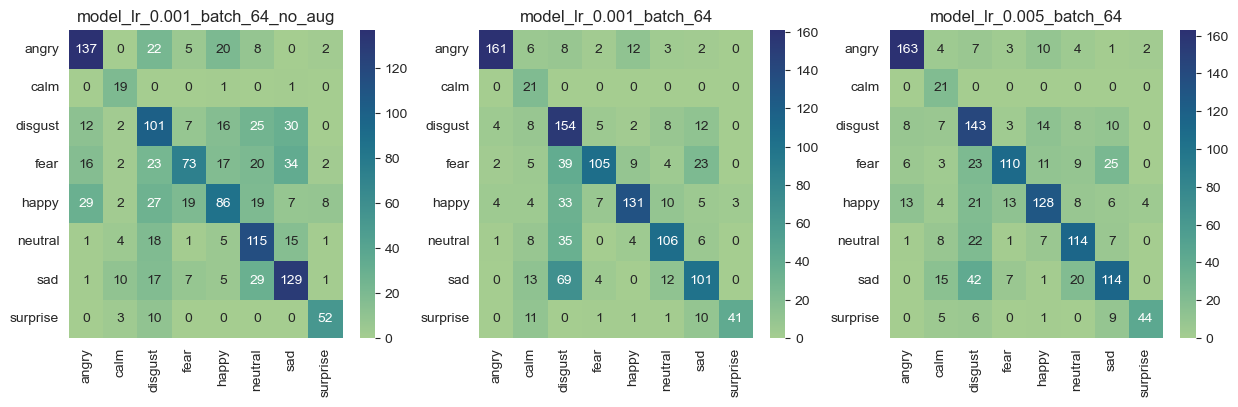

In [132]:
def inference(model, device, test_loader):
    criterion = nn.CrossEntropyLoss()
    model.eval()
    test_pbar = tqdm(test_loader, position=0, leave=True)
    avg_loss = []
    avg_acc = []
    all_y = []
    all_pred_y = []
    with torch.no_grad():
        for X, y in test_pbar:
            X, y = X.to(device), y.to(device)
            output = model(X)
            loss = criterion(output, y)
            
            _, pred_y = torch.max(output, -1)
            acc = (pred_y==y).sum() / len(y)
            
            avg_loss.append(loss.detach().item())
            avg_acc.append(acc.detach().item())
            
            all_y += y.cpu().numpy().tolist()
            all_pred_y += pred_y.cpu().numpy().tolist()
    avg_loss = np.mean(avg_loss)
    avg_acc = np.mean(avg_acc)
    print(f"test_avg_loss:{avg_loss}, test_avg_acc:{avg_acc}")
    return np.array(all_y), np.array(all_pred_y), avg_loss, avg_acc

def get_history(class_names):
    acc_history = []
    model_paths = list(glob.glob("./model_lr_*_batch_64*"))
    fig, ax = plt.subplots(1,3, figsize=(15, 4))
    for idx, model_path in enumerate(model_paths):
        model = Classifier(input_dim, output_dim)
        model.load_state_dict(torch.load(model_path, weights_only=True))
        model = model.to(device)
        y_test, pred_y_test, avg_loss, avg_acc = inference(model, device, test_loader)
        acc_history.append([model_path.split("/")[-1].split(".pth")[0], round(avg_acc,2)])
        cm = pd.DataFrame(confusion_matrix(y_test, pred_y_test), index=class_names, columns=class_names)
        sns.heatmap(cm, annot=True, fmt=".0f", cmap="crest", ax=ax[idx])
        ax[idx].set_title(f"{model_path.split('/')[-1].split('.pth')[0]}")
    acc_df = pd.DataFrame(acc_history, columns=["model_name", "Test_Accuracy"]).sort_values("Test_Accuracy", ascending=False)
    return acc_df
class_names = labelencoder.classes_
acc_df = get_history(class_names)
acc_df

In [72]:
#print(classification_report(y_test, pred_y_test, target_names=labelencoder.classes_))

              precision    recall  f1-score   support

       angry       0.82      0.80      0.81       585
        calm       0.47      0.96      0.63        53
     disgust       0.59      0.61      0.60       559
        fear       0.74      0.54      0.62       575
       happy       0.70      0.64      0.67       573
     neutral       0.65      0.71      0.68       523
         sad       0.63      0.74      0.68       596
    surprise       0.90      0.88      0.89       184

    accuracy                           0.69      3648
   macro avg       0.69      0.73      0.70      3648
weighted avg       0.70      0.69      0.69      3648



 # Visualization


<Axes: title={'center': 'Sample Size of Each Emotion Category'}, xlabel='Label', ylabel='Samples Ratio (%)'>

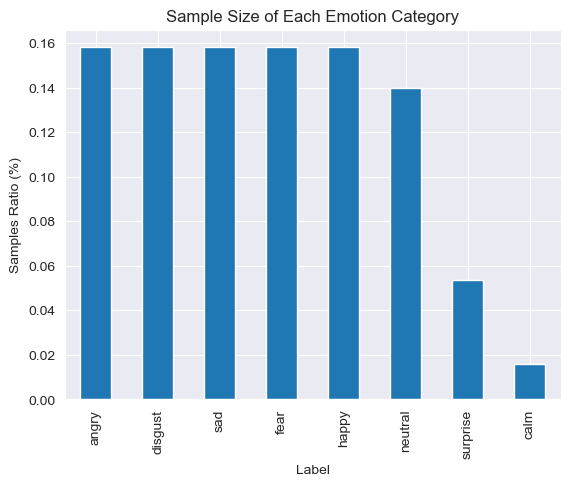

In [130]:
datainfo["Label"].value_counts(normalize=True).plot(kind="bar", title="Sample Size of Each Emotion Category",\
                                                    ylabel="Samples Ratio (%)")

[-0.00036621 -0.00091553 -0.00100708 ...  0.          0.
  0.        ] 16000 3.6703125


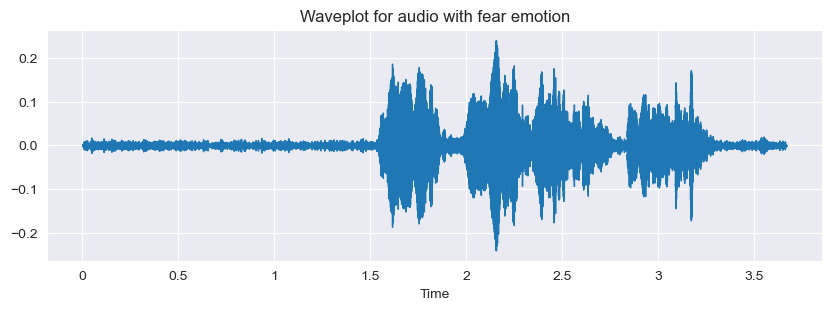

[-0.00222444 -0.00438876 -0.00241886 ...  0.00088998  0.00125552
  0.00109406] 16000 3.6703125


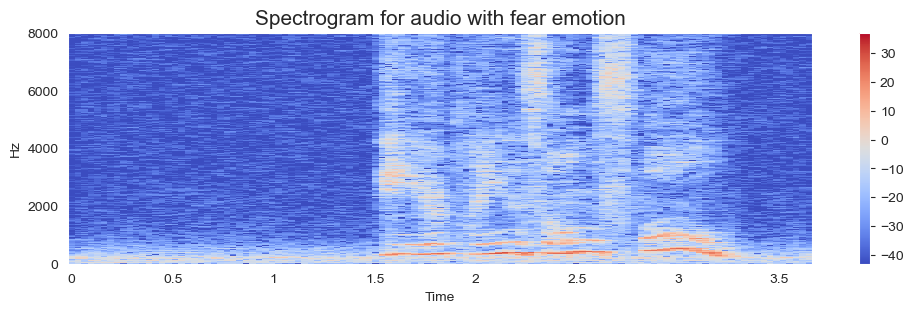

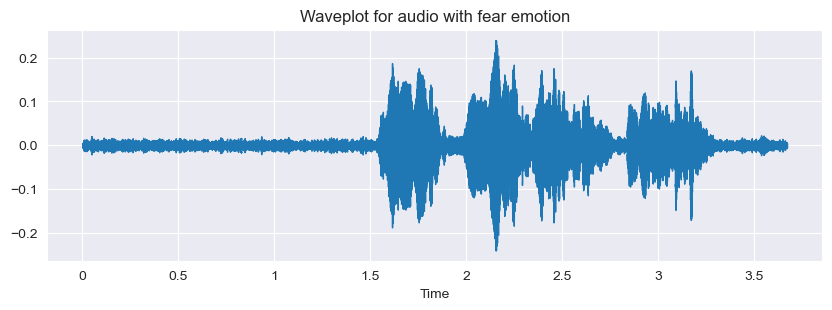

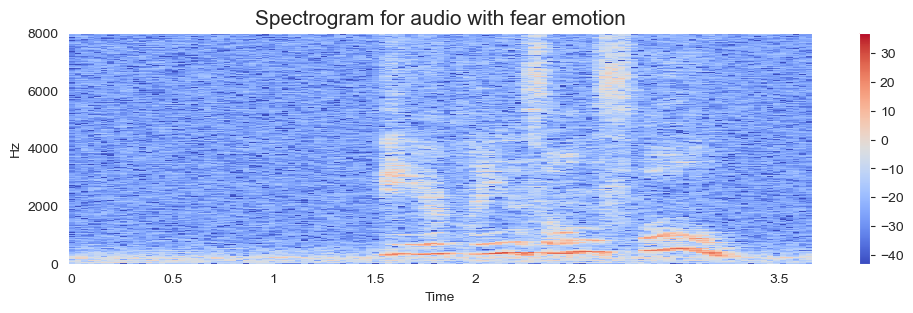

In [131]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10,3))
    plt.title(f"Waveplot for audio with {e} emotion")
    librosa.display.waveshow(data, sr=sr)
    plt.show()
    
def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X)) #將幅度譜轉換為分貝刻度的譜
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data += noise_amp*np.random.normal(size=data.shape[0])
    return data

    
emotion = "fear"
path = datainfo["Path"][datainfo["Label"]==emotion].values[0]
data, sampling_rate = librosa.load(path, sr=16000)
print(data, sampling_rate, len(data)/sampling_rate)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(data = data, rate=sampling_rate)

noise_data = noise(data)
print(noise_data, sampling_rate, len(data)/sampling_rate)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(data = data, rate=sampling_rate)

In [84]:
from torchsummary import summary
model = model.to("cpu")
summary(model, input_size=(input_dim,), batch_size=config["batch_size"], device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [64, 256]          41,728
       BatchNorm1d-2                  [64, 256]             512
              ReLU-3                  [64, 256]               0
            Linear-4                  [64, 128]          32,896
       BatchNorm1d-5                  [64, 128]             256
              ReLU-6                  [64, 128]               0
           Dropout-7                  [64, 128]               0
            Linear-8                   [64, 64]           8,256
       BatchNorm1d-9                   [64, 64]             128
             ReLU-10                   [64, 64]               0
           Linear-11                   [64, 32]           2,080
      BatchNorm1d-12                   [64, 32]              64
             ReLU-13                   [64, 32]               0
          Dropout-14                   

In [31]:
obj = GettingDatasetInfo()

info = obj.AudioWAV_dataset()
c_emotions = info.Label.unique()
d = pd.DataFrame(["True"]*len(c_emotions), index=c_emotions, columns=["AudioWAV"])

info = obj.RAVDESS_dataset()
c_emotions = info.Label.unique()
d2 = pd.DataFrame(["True"]*len(c_emotions), index=c_emotions, columns=["RAVDESS"])
d = d.merge(d2, left_index=True, right_index=True, how="outer")

info = obj.SAVEE_dataset()
c_emotions = info.Label.unique()
d2 = pd.DataFrame(["True"]*len(c_emotions), index=c_emotions, columns=["SAVEE"])
d = d.merge(d2, left_index=True, right_index=True, how="outer")

info = obj.TESS_dataset()
c_emotions = info.Label.unique()
d2 = pd.DataFrame(["True"]*len(c_emotions), index=c_emotions, columns=["TESS"])
d = d.merge(d2, left_index=True, right_index=True, how="outer")
df = d.T.replace({"True":"✓", np.nan:""})

df.index = [f"Crowd Sourced Emotional Multimodal Actors Dataset (CREMA-D)", 
            f"Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS)",
            f"Surrey Audio-Visual Expressed Emotion (SAVEE)",
            f"Toronto emotional speech set (TESS)"]
df

,angry,calm,disgust,fear,happy,neutral,sad,surprise
Crowd Sourced Emotional Multimodal Actors Dataset (CREMA-D),✓,,✓,✓,✓,✓,✓,
Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS),✓,✓,✓,✓,✓,✓,✓,✓
Surrey Audio-Visual Expressed Emotion (SAVEE),✓,,✓,✓,✓,✓,✓,✓
Toronto emotional speech set (TESS),✓,,✓,✓,✓,✓,✓,✓


# Future Work

In [102]:
from pyAudioAnalysis import ShortTermFeatures as aF
from pyAudioAnalysis import MidTermFeatures as mF
from pyAudioAnalysis import audioBasicIO as aIO
fs, s = aIO.read_audio_file(path)
print(fs, s)
mt, st, mt_n = mF.mid_feature_extraction(s, fs, 1*fs, 1*fs, 0.05*fs, 0.05*fs)

16000 [ 77 102 107 ...   0   0   0]
